# Ejercicio 1


Consideramos las tres redes de interacción de proteínas que describen a un mismo sistema pero mediante diferentes métodos. Tenemos: red de interacciones binarias (Y2H), de copertenencia a complejos proteicos (AP-MS) y obtenida de la literatura (LIT). 

Primero, importamos las librerías que usaremos a lo largo del ejercicio, junto con una función para cargar los datos:

In [1]:
import numpy as np
import networkx as nx

from matplotlib import pyplot as plt
%matplotlib notebook

import pandas as pd
from IPython.display import display

def ldata(archive):
    f = open(archive)
    data = []
    for line in f:
        line = line.strip()
        col = line.split()
        data.append(col)
    return data

Cargamos los datos y creamos los grafos. Luego, graficamos las tres redes en una misma figura a modo de comparación cualitativa.

In [2]:
Y2H=ldata("TC01_data/yeast_Y2H.txt")

LIT=ldata("TC01_data/yeast_LIT.txt")

APMS=ldata("TC01_data/yeast_AP-MS.txt")

G_Y2H = nx.Graph(); G_LIT = nx.Graph(); G_APMS = nx.Graph();
G_Y2H.add_edges_from(Y2H); G_LIT.add_edges_from(LIT); G_APMS.add_edges_from(APMS); 

<IPython.core.display.Javascript object>


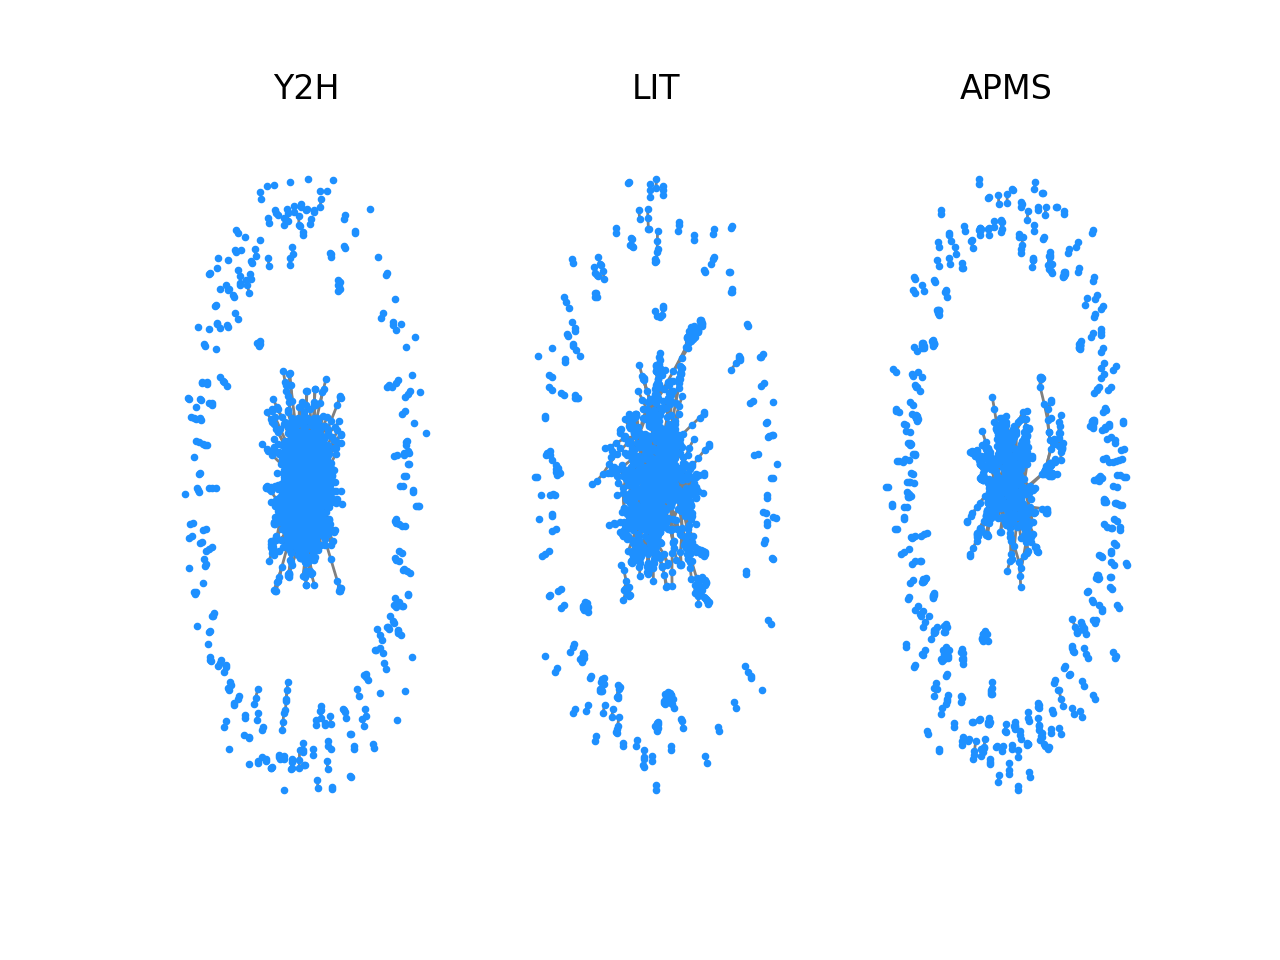

In [3]:
def draw_GraphStyle(G):
    nx.draw(G,
            node_size = 3, 
            node_color = 'dodgerblue',
            edge_color = 'grey'
            )

f, (ax1,ax2,ax3) = plt.subplots(1,3)

plt.sca(ax1)
draw_GraphStyle(G_Y2H)
ax1.set_title('Y2H')

plt.sca(ax2)
draw_GraphStyle(G_LIT)
ax2.set_title('LIT')

plt.sca(ax3)
draw_GraphStyle(G_APMS)
ax3.set_title('APMS')

plt.show()

Se trata de redes no dirigidas, pues representan interacciones entre proteínas y nos interesa únicamente si existe o no vínculo entre ellas.

Calculamos a continuación algunas características cuantitativas para cada red: número total de nodos $N$, número total de enlaces $L$, grado medio $\langle k \rangle$, grado máximo $k_{max}$, grado mínimo $k_{min}$, densidad, diámetro y coeficientes de clustering $\langle C_i \rangle$ (coef. local promedio) y $C_{\Delta}$ (transitividad o coef. global). El diámetro es la distancia máxima entre dos nodos presente en una red (recordemos que distancia es el camino de menor longitud entre dos nodos dados). De esta manera, como el diametro de las tres redes resulta "infinito", se calculó en su lugar el diámetro de la componente gigante $CG$. La densidad consiste en el número total de enlaces sobre el número total de enlaces posibles $N\cdot (N-1)$, que en el caso de red no dirigida se multiplica por factor $\frac{1}{2}$.

In [46]:
#Devuelve una lista con el grado de cada nodo
def degrees2list(grafo):
    lista = list(dict(grafo.degree).values())
    return lista

redes = [G_Y2H,G_LIT,G_APMS]

nodes = []; edges = []; kmedio = []; kmax = []; kmin = []; 
clustl = []; clustg = []; densidad = []; diam = [];

pos = 0

for red in redes:
    nodes.append(red.number_of_nodes())
    edges.append(red.number_of_edges())
    k=degrees2list(red)
    kmedio.append(np.mean(k))
    kmax.append(max(k))
    kmin.append(min(k))
    densidad.append(edges[pos]/(nodes[pos]*(nodes[pos]-1)/2))
    compgigante=max(nx.connected_component_subgraphs(red),key=len)
    diam.append(nx.diameter(compgigante))
    clustl.append(nx.average_clustering(red))
    clustg.append(nx.transitivity(red))
    pos+=1

Creamos un DataFrame de pandas para colocar los valores calculados:

In [45]:
caract = pd.DataFrame({ 'red':['Y2H','LIT','APMS'], 
                        'N':nodes,
                        'L':edges,
                        'k_medio':kmedio,
                        'k_max':kmax,
                        'k_min':kmin,
                        'densidad':densidad,
                        'c_local':clustl,
                        'c_global':clustg,
                        'diam_CG':diam
                      })

caract = caract[['red','N','L','k_medio',
                 'k_max','k_min','densidad','c_local',
                 'c_global','diam_CG']]

display(caract)

,red,N,L,k_medio,k_max,k_min,densidad,c_local,c_global,diam_CG
0,Y2H,2018,2930,2.903865,91,1,0.001440,0.046194,0.023614,14
1,LIT,1536,2925,3.808594,40,1,0.002481,0.292492,0.346193,19
2,APMS,1622,9070,11.183724,127,1,0.006899,0.554636,0.618590,15


### Del experimento a la red

Por último, nos interesó extraer más información sobre la red AP-MS relevada mediante copertenencia a complejos proteicos. Nos preguntamos si es posible determinar de qué manera (spoke o matrix) se asignaron los enlaces entre proteínas de un mismo complejo. Matrix consiste en enlazar todas con todas, de modo que los coefs. de clustering del conjunto resultan $\langle C_i \rangle = C_{\Delta}=1$, mientras que spoke asgina una red tipo "star" con centro en la proteína principal.

Para esto, creamos nuevas keys al diccionario graph asociado a cada red (graph es un atributo). La idea fue tratar por separado las componentes de los grafos y tomar valor medio de las propiedades de cada una (i.e $\langle k \rangle$, $\langle C_i \rangle$, densidad). La componente gigante se trató por separado, debido a que tiene mucho más peso sobre las propiedades del grafo en general.

In [59]:
for red in redes:
    
    #Lista cuyos elementos son las componentes de la red 
    red.graph["comp"] = list(nx.connected_component_subgraphs(red))
    
    #Removemos la componente gigante
    compgigante = max(red.graph["comp"], key=len)
    red.graph["comp"].remove(compgigante)
    
    #Densidad de la componente gigante
    nCG = compgigante.number_of_nodes()
    eCG = compgigante.number_of_edges()
    red.graph["dens_CG"] = eCG/(nCG*(nCG-1)/2)
    
    #Clust. local promedio y clust. global de la componente gigante
    red.graph["c_local_CG"] = nx.average_clustering(compgigante)
    red.graph["c_global_CG"] = nx.transitivity(compgigante)
    
    clustl_comp = []; #Lista con coefs. de clustering local promedio de cada componente 
    clustg_comp = []; #Lista con coef. de clustering global de cada componente
    dens_comp = [];   #Lista con la densidad de cada componente
    
    #Colocamos los elementos de cada lista
    for comp in red.graph["comp"]:
        clustl_comp.append(nx.average_clustering(comp))
        clustg_comp.append(nx.transitivity(comp))
        n = comp.number_of_nodes()
        e = comp.number_of_edges()
        if n != 1:
            dens_comp.append(e/(n*(n-1)/2))
        else:
            dens_comp.append(0)
    
    #Creamos las keys asociadas a las componentes y les asignamos los valores 
    red.graph["c_local_comp"] = clustl_comp 
    red.graph["c_global_comp"] = clustg_comp
    red.graph["densidad_comp"] = dens_comp


A continuación, usando estas nuevas propiedades, se calculan los valores que nos van a permitir comparar características entre las redes. Luego se colocarán en un DataFrame. 

In [60]:
n_comps = []; n_clustl1 = []; n_clustg1 = []; prom_cl = []; prom_cg = [];
clustl_CG = []; clustg_CG = []; prom_dens_comp = []; dens_cg = [];

for red in redes:
    
    #Número de componentes
    n_comps.append(len(red.graph["comp"]))
    
    #Promedio de los coeficientes de clustering de las componentes
    clustl_comp = red.graph["c_local_comp"]
    clustg_comp = red.graph["c_global_comp"]
    prom_cl.append(np.mean(clustl_comp))
    prom_cg.append(np.mean(clustg_comp))
    
    #Coefs. de clustering de la componente gigante
    clustl_CG.append(red.graph["c_local_CG"])
    clustg_CG.append(red.graph["c_global_CG"])
    
    #Cantidad de componentes con coef. de clustering =1
    n_clustl1.append(sum([int(i==1) for i in clustl_comp]))
    n_clustg1.append(sum([int(i==1) for i in clustg_comp]))
    
    #Promedio de la densidad de las componentes
    prom_dens_comp.append(np.mean(red.graph["densidad_comp"]))
    
    #Densidad de la comp. gigante
    dens_cg.append(red.graph["dens_CG"])

In [61]:
caract2 = pd.DataFrame({ "red":["Y2H","LIT","APMS"],
                         "n_comps":n_comps,
                         "prom_c_local_comp":prom_cl,
                         "prom_c_global_comp":prom_cg,
                         "c_local_CG":clustl_CG,
                         "c_global_CG":clustg_CG,
                         "n_c_local_1":n_clustl1,
                         "n_c_global_1":n_clustg1,
                         "prom_dens_comp":prom_dens_comp,
                         "dens_CG":dens_cg,
                         })
    
caract2 = caract2[['red','n_comps','prom_dens_comp','dens_CG','prom_c_local_comp',
                   'prom_c_global_comp','c_local_CG','c_global_CG',
                   'n_c_local_1','n_c_global_1']]

display(caract2)

,red,n_comps,prom_dens_comp,dens_CG,prom_c_local_comp,prom_c_global_comp,c_local_CG,c_global_CG,n_c_local_1,n_c_global_1
0,Y2H,184,0.672464,0.001979,0.000000,0.000000,0.056600,0.023667,0,0
1,LIT,97,0.777247,0.003566,0.078751,0.078682,0.327861,0.345697,2,2
2,APMS,192,0.896247,0.016522,0.242976,0.242864,0.647514,0.617168,23,23


Interpretemos los datos de la tabla. Podemos ver que la densidad de la componente gigante de la red AP-MS es un orden de magnitud mayor en comparación a las otras dos redes. El promedio de la densidad de las componentes también resulta mayor para la red AP-MS. Como las tres redes describen el mismo sistema, este podría ser el primer motivo para sospechar que se sobreestimó el número de enlaces en el método AP-MS: probablemente se utilizó la asginación de enlaces tipo matrix. 

Si ahora miramos el clustering, notamos que el promedio de los coeficientes de las componentes de la red AP-MS es de nuevo un orden de magnitud mayor al de la red LIT y mucho mayor al de la red Y2H que presenta este valor como cero (si bien esto resulta curioso, puede tener sentido si consideramos que el método de relevamiento Y2H es el más conservador en cuanto a enlaces, pues se obtienen directamente interacciones binarias). Más aún: la red AP-MS presenta $\frac{23}{192}$ componentes con clustering máximo, mientras que LIT presenta $\frac{2}{97}$ y Y2H $\frac{0}{184}$. Además, los coeficientes de clustering de la componente gigante en la red AP-MS son también más grandes que en las otras dos. Todo indicaría nuevamente que el método de asignación de enlaces en los complejos proteicos del AP-MS fue el de matrix. 

Este análisis de las componentes consideradas individualemente sirvió para reforzar y dar más solidez a conlusiones que ya se veían en el primer DataFrame, donde se observa claramente que si bien las tres tienen un número de nodos similar, la cantidad de enlaces es al menos el triple en la red AP-MS que en las otras. Además, la densidad, el $k_{max}$ y los coeficientes de clustering son mayores para esta red. Todos estos factores, si bien describen características topológicas diferentes, nos indican una cantidad notablemente mayor de enlaces en el método AP-MS en comparación con los otros dos métodos.